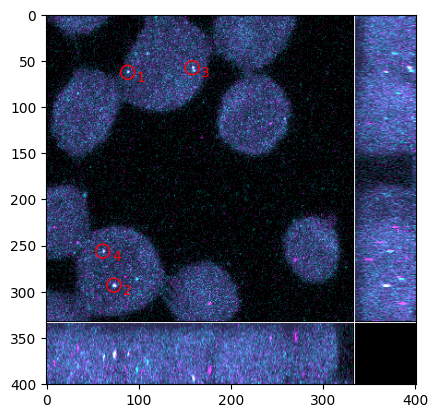

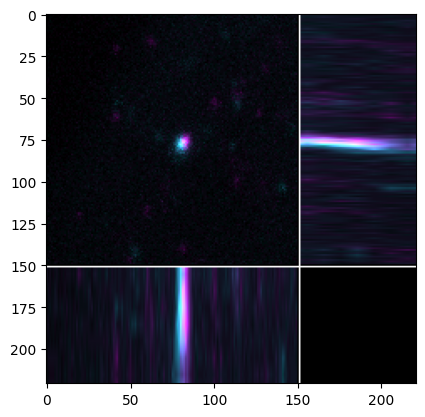

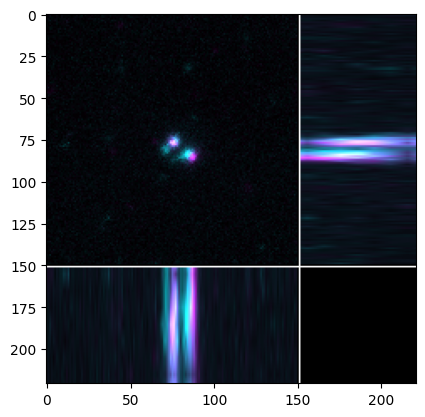

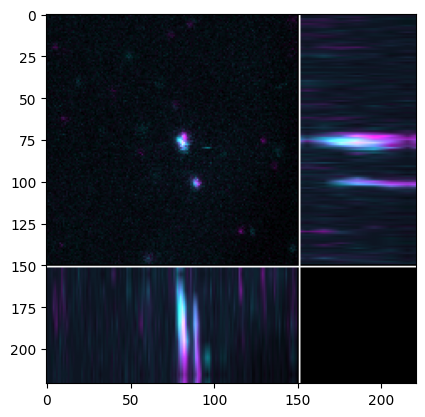

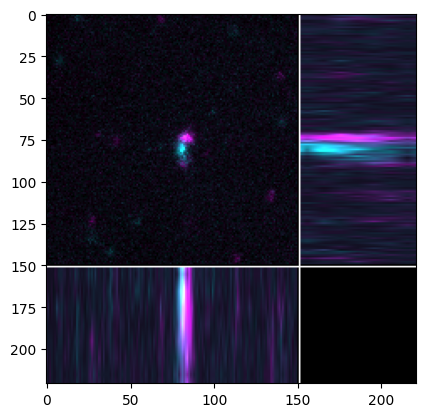

In [5]:
from glob import glob
from xml.etree import ElementTree as et

import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imsave

from calmutils.misc.visualization import get_orthogonal_projections_8bit
from calmutils.color import gray_images_to_rgb_composite
from msr_reader import OBFFile

file_pattern = 'compaction_sted_data/39_KB_20171213/A92_KB_K562_wt_Dead11B-Atto594_Dead11A-Atto647N/K562_wt/raw/dd78e085753290968d623de3ee7dc8a6_field20_sted*.msr'
files = glob(file_pattern)

ov_img1, ov_img2 = None, None
details_imgs = []
detail_positions = []

for file in files:

    with OBFFile(file) as reader:

        ov_img1, ov_img2 = reader.read_stack(0), reader.read_stack(1)
        ov_psz = np.array(reader.pixel_size(0))
        det_psz = np.array(reader.pixel_size(2))

        xml_imspector_metadata_ov_s = reader.get_imspector_xml_metadata(0)
        xml_metadata_ov = et.fromstring(xml_imspector_metadata_ov_s)
        off_ov = np.array([xml_metadata_ov.find(f'doc/ExpControl/scan/range/{dim}/off').text for dim in 'zyx']).astype(float)

        xml_imspector_metadata_det_s = reader.get_imspector_xml_metadata(2)
        xml_metadata_det = et.fromstring(xml_imspector_metadata_det_s)
        off_det = np.array([xml_metadata_det.find(f'doc/ExpControl/scan/range/{dim}/off').text for dim in 'zyx']).astype(float)

        detail_positions.append(((off_det - off_ov) / ov_psz + np.array(ov_img1.shape) / 2).astype(int))

        details_imgs.append((reader.read_stack(2), reader.read_stack(3)))

detail_positions = np.array(detail_positions)

rgb_img = gray_images_to_rgb_composite([get_orthogonal_projections_8bit(img, pixel_size=ov_psz) for img in [ov_img1, ov_img2]], color_names=['cyan', 'magenta'])
plt.imshow(rgb_img)
plt.scatter(*detail_positions.T[-1:0:-1], marker='o', facecolors='none', edgecolors='red', s=100)
for i, (y, x) in enumerate(detail_positions[:,1:]):
    plt.annotate(str(i+1), [x+10, y+10], color='red')
imsave(f'fish_overview.png', (rgb_img*255).astype(np.uint8))


for i, imgs in enumerate(details_imgs):
    rgb_img = gray_images_to_rgb_composite([get_orthogonal_projections_8bit(img, pixel_size=det_psz) for img in imgs], color_names=['cyan', 'magenta'])
    plt.figure()
    plt.imshow(rgb_img)
    imsave(f'fish_detail_{i+1}.png', (rgb_img*255).astype(np.uint8))